# Sentiment analysis
Gorbunov Andrey, Efimov Alexander

In [42]:
import pandas as pd
import numpy as np
import re
import nltk
import random
import string
from tensorflow.keras.preprocessing.text import Tokenizer       
from nltk.corpus import stopwords 
from nltk.stem import PorterStemmer
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Flatten
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from PIL import Image

## Data analysis

In [43]:
# Read data
tweets = pd.read_csv("Twitter_Data.csv")
tweets['clean_text'] = tweets['clean_text'].astype('str')
tweets.dropna(inplace=True)
print(tweets.shape)
tweets.head(3)

(162973, 2)


,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0


In [44]:
# Separate all tweets into categories
all_positive_tweets = tweets[tweets['category'] == 1]['clean_text']
all_neutral_tweets = tweets[tweets['category'] == 0]['clean_text']
all_negative_tweets = tweets[tweets['category'] == -1]['clean_text']

In [45]:
total_positive_words = np.array([len(sentence.split()) for sentence in all_positive_tweets])
total_neutral_words = np.array([len(sentence.split()) for sentence in all_neutral_tweets])
total_negative_words = np.array([len(sentence.split()) for sentence in all_negative_tweets])

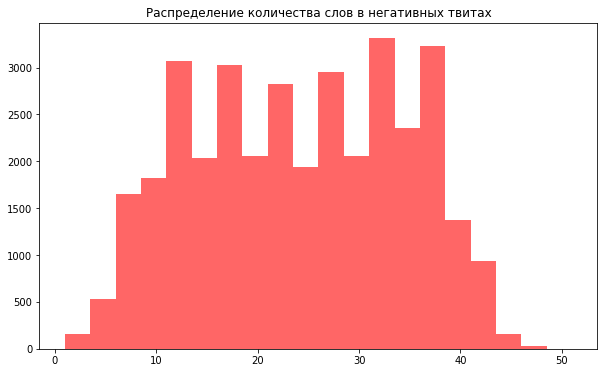

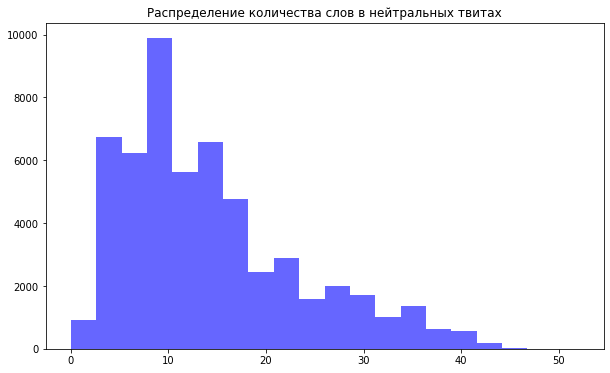

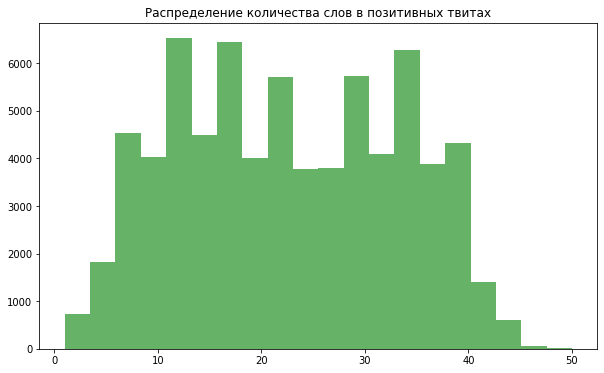

In [46]:
# Tweets length distribution (number of words per tweet)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot()
ax.hist(total_negative_words, bins=20, alpha=0.6, color='red');
ax.set_title('Распределение количества слов в негативных твитах');

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot()
ax.hist(total_neutral_words, bins=20, alpha=0.6, color='blue');
ax.set_title('Распределение количества слов в нейтральных твитах');

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot()
ax.hist(total_positive_words, bins=20, alpha=0.6, color='green');
ax.set_title('Распределение количества слов в позитивных твитах');

plt.show();

 1.0    72250
 0.0    55213
-1.0    35510
Name: category, dtype: int64


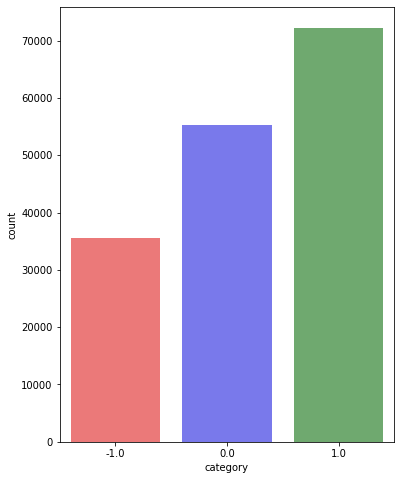

In [47]:
# Визуализация распределения лейблов
plt.figure(figsize=(6, 8));
sns.countplot(x = tweets['category'], palette=['red', 'blue', 'green'], alpha=0.6);
print(tweets['category'].value_counts())

Positive tweets


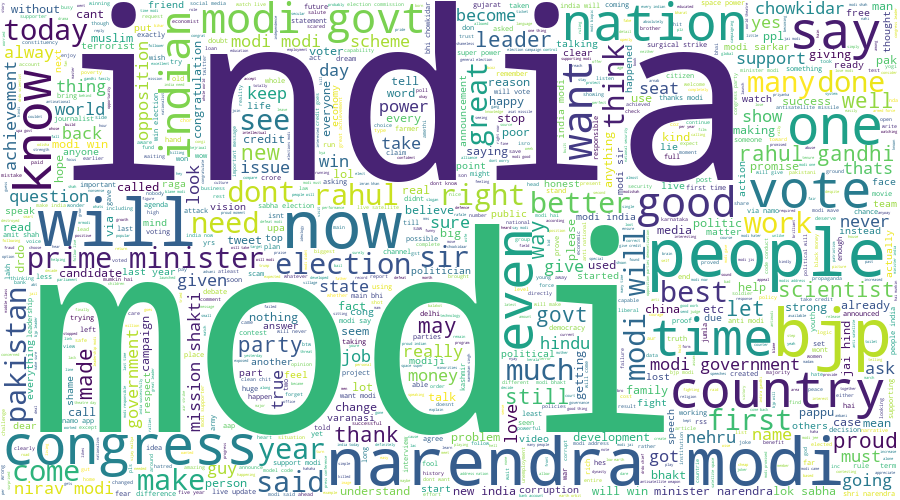

In [48]:
from wordcloud import WordCloud

def create_wordcloud(text,path):
    wc = WordCloud(background_color="white",
                   max_words=3000,
                   random_state=42,
                   width=900, height=500,
                   repeat=True)
    wc.generate(text)
    wc.to_file(path)
    display(Image.open(path))
    
print("Positive tweets")
create_wordcloud(all_positive_tweets.str.cat(sep = " "),"positive.png")
# print("Negative tweets")
# create_wordcloud(all_negative_tweets.str.cat(sep = " "),"negative.png")
# print("Neutral tweets")
# create_wordcloud(all_neutral_tweets.str.cat(sep = " "),"neutral.png")

## Data Preparation

In [49]:
# get english stopwords
stopwords_english = stopwords.words('english') 

print('Stop words\n')
print(stopwords_english)

Stop words

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so

In [50]:
# for example:
tweets['clean_text'][0]

'when modi promised “minimum government maximum governance” expected him begin the difficult job reforming the state why does take years get justice state should and not business and should exit psus and temples'

In [51]:
# Remove stopwords
tweets['clean_text'] = \
    tweets['clean_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords_english)]))

In [52]:
tweets['clean_text'][0]

'modi promised “minimum government maximum governance” expected begin difficult job reforming state take years get justice state business exit psus temples'

In [53]:
# Remove punctuations
tweets['clean_text'] = tweets['clean_text'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

In [54]:
tweets['clean_text'][0]

'modi promised minimum government maximum governance expected begin difficult job reforming state take years get justice state business exit psus temples'

## Stemming

In [55]:
%%time
stemmer = PorterStemmer() 
def stemming(sentence):
    stemmed_words = [stemmer.stem(word) for word in sentence.split()]
    return ' '.join(stemmed_words)
    
tweets['clean_text'] = tweets['clean_text'].apply(lambda x: stemming(x))

CPU times: total: 40.4 s
Wall time: 40.6 s


In [56]:
tweets['clean_text'][0]

'modi promis minimum govern maximum govern expect begin difficult job reform state take year get justic state busi exit psu templ'

In [57]:
# shift category numbers to 0-2
tweets['category'] = tweets['category'] + 1

## Tokenization & padding

In [58]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tweets['clean_text'])
word_index = tokenizer.word_index

vocab_size = len(word_index)+1

In [59]:
# padding the tokenized sequences to same length
print(f'max_length of existing tweets = {tweets.clean_text.apply(lambda x: len(x.split())).max()}')
max_length = 50
lines = pad_sequences(tokenizer.texts_to_sequences(tweets.clean_text), maxlen = max_length)

tweets['clean_text'] = lines.tolist()

max_length of existing tweets = 43


In [60]:
tweets.head(3)

,clean_text,category
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2.0


## Making a Sequential model

In [61]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(tweets['clean_text'], tweets['category'], test_size=0.2, random_state=42,
                                                stratify=tweets['category'])

X_train = np.vstack(X_train.values)
y_train = np.vstack(y_train.values)

X_test = np.vstack(X_test.values)
y_test = np.vstack(y_test.values)

In [21]:
model = tf.keras.Sequential()

model.add(Input(shape=(None,)))
model.add(Embedding(input_dim=vocab_size,output_dim=200,trainable=True))
model.add(LSTM(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 200)         17711000  
                                                                 
 lstm (LSTM)                 (None, 64)                67840     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 17,783,195
Trainable params: 17,783,195
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.compile(optimizer=Adam(clipnorm=1.0), loss=keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
history = model.fit(X_train, y_train,
                    epochs=2, batch_size=512,
                    verbose=1,shuffle=True,validation_data=(X_test,y_test))

Epoch 1/2
255/255 [==============================] - 81s 314ms/step - loss: 0.6294 - accuracy: 0.7435 - val_loss: 0.4081 - val_accuracy: 0.8570
Epoch 2/2
255/255 [==============================] - 81s 316ms/step - loss: 0.3521 - accuracy: 0.8767 - val_loss: 0.4004 - val_accuracy: 0.8541


## Results

In [23]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=128)

Evaluate on test data
255/255 [==============================] - 4s 17ms/step - loss: 0.4004 - accuracy: 0.8541


In [24]:
predictions = model.predict(X_test)
print(classification_report(y_test, np.argmax(predictions, axis=1), target_names=('negative','neutral','positive')))

              precision    recall  f1-score   support

    negative       0.80      0.77      0.79      7102
     neutral       0.86      0.89      0.87     11043
    positive       0.88      0.87      0.87     14450

    accuracy                           0.85     32595
   macro avg       0.84      0.84      0.84     32595
weighted avg       0.85      0.85      0.85     32595



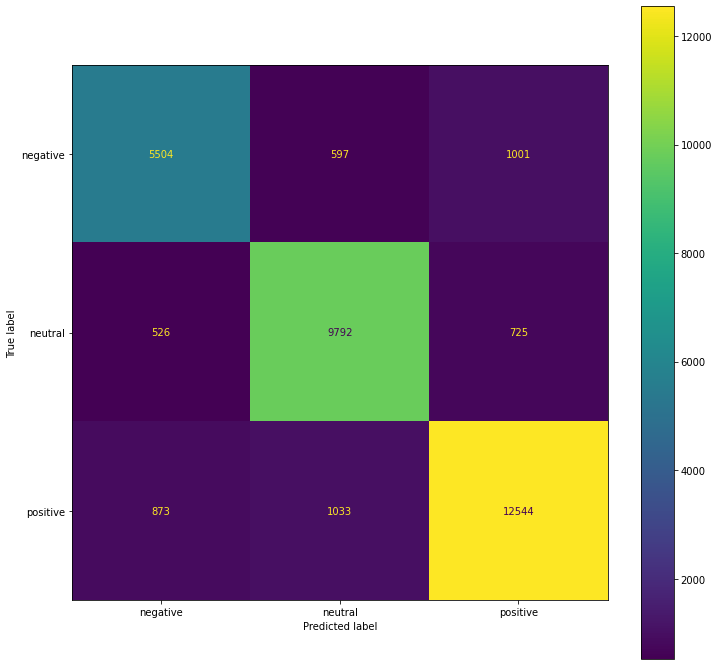

In [25]:
# Confusion matrix
cm = confusion_matrix(y_test, np.argmax(predictions, axis=1))
cm_display = ConfusionMatrixDisplay(cm, display_labels=['negative','neutral','positive'])

fig, ax = plt.subplots(figsize=(12,12))
cm_display.plot(ax=ax)

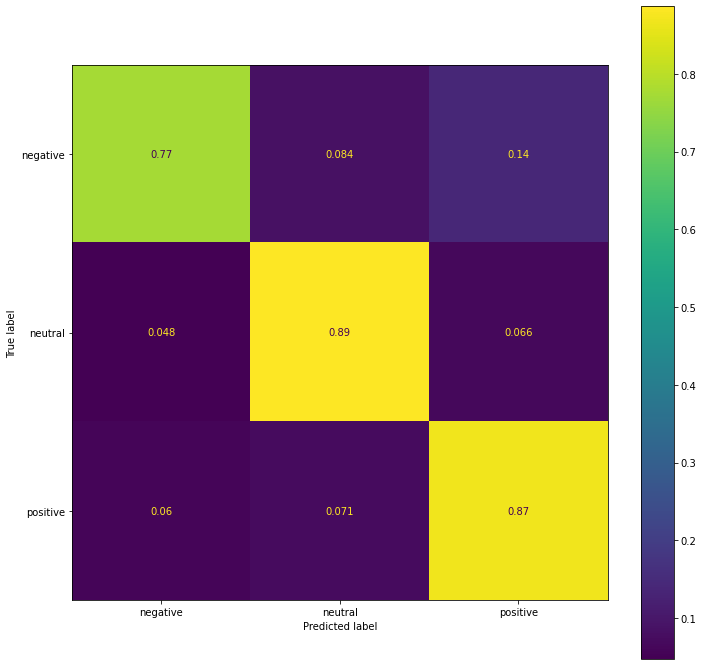

In [26]:
# Normalized confusion matrix
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

cmn_display = ConfusionMatrixDisplay(cmn, display_labels=['negative','neutral','positive'])

fig, ax = plt.subplots(figsize=(12,12))
cmn_display.plot(ax=ax)

In [62]:
model2 = tf.keras.Sequential()

model2.add(Embedding(input_dim=vocab_size,input_length=max_length,output_dim=100))
model2.add(Flatten())
model2.add(Dense(64, activation='relu'))
model2.add(Dense(64, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(3, activation='softmax'))

model2.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 50, 100)           8855500   
                                                                 
 flatten_5 (Flatten)         (None, 5000)              0         
                                                                 
 dense_18 (Dense)            (None, 64)                320064    
                                                                 
 dense_19 (Dense)            (None, 64)                4160      
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_20 (Dense)            (None, 3)                 195       
                                                                 
Total params: 9,179,919
Trainable params: 9,179,919
No

In [65]:
model2.compile(optimizer=Adam(clipnorm=1.0), loss=keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
history = model2.fit(X_train, y_train,
                    epochs=2, batch_size=64,
                    verbose=1,shuffle=True,validation_data=(X_test,y_test))

Epoch 1/2
2038/2038 [==============================] - 176s 86ms/step - loss: 0.3631 - accuracy: 0.8731 - val_loss: 0.4464 - val_accuracy: 0.8401
Epoch 2/2
2038/2038 [==============================] - 180s 88ms/step - loss: 0.1879 - accuracy: 0.9380 - val_loss: 0.5986 - val_accuracy: 0.8198


In [66]:
predictions2 = model2.predict(X_test)
print(classification_report(y_test, np.argmax(predictions2, axis=1), target_names=('negative','neutral','positive')))

              precision    recall  f1-score   support

    negative       0.79      0.67      0.72      7102
     neutral       0.81      0.88      0.85     11043
    positive       0.84      0.85      0.84     14450

    accuracy                           0.82     32595
   macro avg       0.81      0.80      0.80     32595
weighted avg       0.82      0.82      0.82     32595



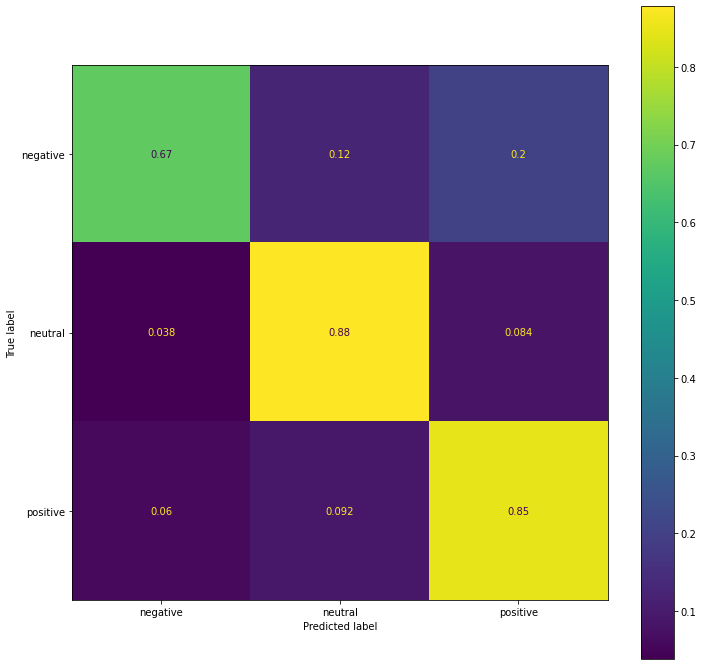

In [67]:
# Normalized confusion matrix
cm2 = confusion_matrix(y_test, np.argmax(predictions2, axis=1))
cmn2 = cm2.astype('float') / cm2.sum(axis=1)[:, np.newaxis]

cmn_display2 = ConfusionMatrixDisplay(cmn2, display_labels=['negative','neutral','positive'])

fig, ax = plt.subplots(figsize=(12,12))
cmn_display2.plot(ax=ax)